In [1]:
!pip install loss-landscapes

In [7]:
import torch
import torchvision
import torchvision.transforms as transforms
from tqdm import tqdm
import numpy as np

import matplotlib.pyplot as plt
import model_cifar

In [2]:
transform = transforms.Compose(
    [transforms.ToTensor(),
     transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))])

batch_size = 128

trainset = torchvision.datasets.CIFAR10(root='./data', train=True,
                                        download=True, transform=transform)
trainloader = torch.utils.data.DataLoader(trainset, batch_size=batch_size,
                                          shuffle=True)

testset = torchvision.datasets.CIFAR10(root='./data', train=False,
                                       download=True, transform=transform)
testloader = torch.utils.data.DataLoader(testset, batch_size=batch_size,
                                         shuffle=False)

classes = ('plane', 'car', 'bird', 'cat',
           'deer', 'dog', 'frog', 'horse', 'ship', 'truck')

device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

Files already downloaded and verified
Files already downloaded and verified


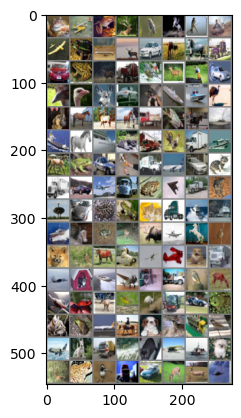

frog  plane frog  deer  bird  horse bird  deer  plane frog  plane deer  car   horse horse truck car   frog  deer  truck bird  deer  bird  car   bird  bird  deer  car   cat   ship  ship  bird  dog   horse deer  horse truck frog  horse ship  ship  horse ship  cat   truck bird  truck ship  horse frog  car   dog   truck plane car   cat   truck car   plane truck frog  plane truck cat   bird  car   frog  frog  cat   truck ship  ship  ship  horse frog  deer  deer  plane horse bird  dog   bird  horse horse plane plane dog   truck plane cat   ship  plane cat   truck bird  deer  plane frog  deer  bird  bird  truck car   frog  cat   frog  plane horse dog   deer  truck bird  plane dog   truck deer  cat   plane ship  cat   deer  frog  bird  truck car   deer  deer  plane


In [4]:
def imshow(img):
    img = img / 2 + 0.5     # unnormalize
    npimg = img.numpy()
    plt.imshow(np.transpose(npimg, (1, 2, 0)))
    plt.show()


# get some random training images
dataiter = iter(trainloader)
images, labels = next(dataiter)

# show images
imshow(torchvision.utils.make_grid(images))



In [4]:
def train(model, criterion, optimizer, trainloader, val_loader, epochs=5, log_interval=10, cur_val_loss=float('inf')):
    model.train()
    model.to(device)
    best_val_loss = cur_val_loss
    for epoch in tqdm(range(epochs)):
        running_loss = 0.0
        for i, data in enumerate(trainloader):
            inputs, labels = data[0].to(device), data[1].to(device)
            optimizer.zero_grad()
            outputs = model(inputs)
            loss = criterion(outputs, labels)
            loss.backward()
            optimizer.step()
            running_loss += loss.item()

        val_loss, val_acc = 0, 0

        for i, data in enumerate(val_loader):
            with torch.no_grad():
                inputs, labels = data[0].to(device), data[1].to(device)
                outputs = model(inputs)
                loss = criterion(outputs, labels)
                val_loss += loss.item()
                val_acc += accuracy(outputs, labels)
        total_val_loss = val_loss / len(val_loader)
        if total_val_loss < best_val_loss:
            best_val_loss = total_val_loss
            torch.save(model.state_dict(), 'best_model.pth')
        if epoch % log_interval == 0:
            print(f'Validation loss: {val_loss / len(val_loader)}')
            print(f'Validation accuracy: {val_acc / len(val_loader)}')
            
def accuracy(outputs, labels):
    _, predicted = torch.max(outputs, 1)
    total = labels.size(0)
    correct = (predicted == labels).sum().item()
    return correct / total

In [5]:
def train_w_scheduler(model, criterion, optimizer, scheduler, trainloader, val_loader, epochs=5, cur_val_loss=float('inf')):
    model.train()
    model.to(device)
    best_val_loss = cur_val_loss
    for epoch in tqdm(range(epochs)):
        running_loss = 0.0
        for i, data in enumerate(trainloader):
            inputs, labels = data[0].to(device), data[1].to(device)
            optimizer.zero_grad()
            outputs = model(inputs)
            loss = criterion(outputs, labels)
            loss.backward()
            optimizer.step()
            scheduler.step()
            running_loss += loss.item()
        val_loss, val_acc = 0, 0
        for i, data in enumerate(val_loader):
            with torch.no_grad():
                inputs, labels = data[0].to(device), data[1].to(device)
                outputs = model(inputs)
                loss = criterion(outputs, labels)
                val_loss += loss.item()
                val_acc += accuracy(outputs, labels)
            if val_loss/len(val_loader) < best_val_loss:
                best_val_loss = val_loss
                torch.save(model.state_dict(), 'best_model.pth')
            print(f'Validation loss: {val_loss / len(val_loader)}')
            print(f'Validation accuracy: {val_acc / len(val_loader)}')

# Visualisation

In [8]:
import loss_landscapes
import loss_landscapes.metrics

import matplotlib
import matplotlib.pyplot as plt
from mpl_toolkits import mplot3d

In [9]:
resnet18 = model_cifar.ResNet20()
optimizer = torch.optim.SGD(resnet18.parameters(), lr=0.1)
criterion = torch.nn.CrossEntropyLoss()
train(resnet18, criterion, optimizer, trainloader, testloader, epochs=10, log_interval=2)

 10%|█         | 1/10 [00:30<04:31, 30.20s/it]

Validation loss: 1.115903160994566
Validation accuracy: 0.6028481012658228


100%|██████████| 10/10 [03:56<00:00, 23.65s/it]


In [10]:
torch.save(resnet18.state_dict(), 'resnet18.pth')

C:\Users\Pierre\AppData\Local\Temp\ipykernel_58096\4091765579.py:13: UserWarning: Matplotlib is currently using module://matplotlib_inline.backend_inline, which is a non-GUI backend, so cannot show the figure.
  fig.show()


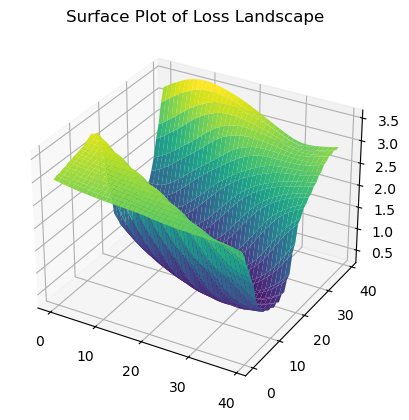

In [30]:
x, y = iter(trainloader).__next__()
STEPS = 40
metric = loss_landscapes.metrics.Loss(criterion, x, y)
model = resnet18.cpu()

loss_data_fin = loss_landscapes.random_plane(model, metric, 2, STEPS, normalization='filter', deepcopy_model=True)
fig = plt.figure()
ax = plt.axes(projection='3d')
X = np.array([[j for j in range(STEPS)] for i in range(STEPS)])
Y = np.array([[i for _ in range(STEPS)] for i in range(STEPS)])
ax.plot_surface(X, Y, loss_data_fin, rstride=1, cstride=1, cmap='viridis', edgecolor='none')
ax.set_title('Surface Plot of Loss Landscape')
fig.show()

# No residual connexion

In [11]:
W_resnet18 = model_cifar.ResNet20_noshort()
optimizer = torch.optim.SGD(W_resnet18.parameters(), lr=0.1)
train(W_resnet18, criterion, optimizer, trainloader, testloader, epochs=10, log_interval=2)

 10%|█         | 1/10 [00:22<03:20, 22.30s/it]

Validation loss: 1.5622739867319035
Validation accuracy: 0.4219738924050633


 30%|███       | 3/10 [01:07<02:36, 22.39s/it]

Validation loss: 0.9411164620254613
Validation accuracy: 0.6651503164556962


 50%|█████     | 5/10 [01:52<01:51, 22.39s/it]

Validation loss: 0.79734402668627
Validation accuracy: 0.7285403481012658


 70%|███████   | 7/10 [02:36<01:06, 22.28s/it]

Validation loss: 0.6693034330500832
Validation accuracy: 0.7709651898734177


 90%|█████████ | 9/10 [03:20<00:22, 22.16s/it]

Validation loss: 0.6355333415013326
Validation accuracy: 0.7862935126582279


100%|██████████| 10/10 [03:42<00:00, 22.26s/it]


In [12]:
torch.save(W_resnet18.state_dict(), 'W_resnet18.pth')

C:\Users\Pierre\AppData\Local\Temp\ipykernel_58096\1263863945.py:13: UserWarning: Matplotlib is currently using module://matplotlib_inline.backend_inline, which is a non-GUI backend, so cannot show the figure.
  fig.show()


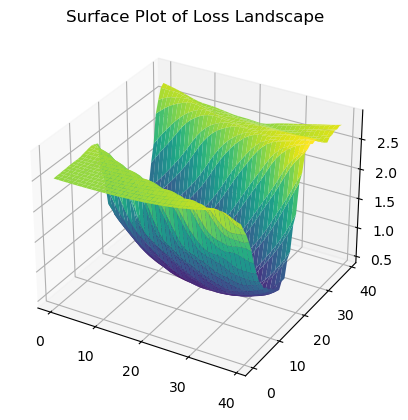

In [31]:
x, y = iter(trainloader).__next__()
STEPS = 40
metric = loss_landscapes.metrics.Loss(criterion, x, y)
model = W_resnet18.cpu()

loss_data_fin = loss_landscapes.random_plane(model, metric, 2, STEPS, normalization='filter', deepcopy_model=True)
fig = plt.figure()
ax = plt.axes(projection='3d')
X = np.array([[j for j in range(STEPS)] for i in range(STEPS)])
Y = np.array([[i for _ in range(STEPS)] for i in range(STEPS)])
ax.plot_surface(X, Y, loss_data_fin, rstride=1, cstride=1, cmap='viridis', edgecolor='none')
ax.set_title('Surface Plot of Loss Landscape')
fig.show()

In [32]:
import plotly.graph_objects as go

In [38]:
z = loss_data_fin
# Create a grid of (x, y) coordinates for the landscape
grid_x, grid_y = np.meshgrid(np.arange(STEPS), np.arange(STEPS))

# Find the range of your z values
z_min, z_max = 0, np.max(z)
# Create layout with adjusted scale
layout = go.Layout(
    scene=dict(
        aspectmode="manual",  # Set aspect mode to manual
        aspectratio=dict(x=1, y=1, z=0.5),  # Set aspect ratios for x, y, and z
        zaxis=dict(range=[z_min, z_max + 1])  # Set the range for the z-axis
    ),
    width=600,  # Set the width of the figure
    height=600,  # Set the height of the figure
)

# Create figure without the trace_surface
fig = go.Figure(layout=layout)

# Add the surface trace to the figure
fig.add_trace(go.Surface(x=X, y=Y, z=z, name='Loss Landscape', colorscale='Viridis'))


# Deeper model

In [13]:
resnet56 = model_cifar.ResNet56()
optimizer = torch.optim.SGD(resnet56.parameters(), lr=0.1)
train(resnet56, criterion, optimizer, trainloader, testloader, epochs=10)

 10%|█         | 1/10 [00:48<07:14, 48.25s/it]

Validation loss: 1.4335729517514193
Validation accuracy: 0.46489319620253167


100%|██████████| 10/10 [08:02<00:00, 48.30s/it]


In [14]:
optimizer = torch.optim.SGD(resnet56.parameters(), lr=0.01)
train(resnet56, criterion, optimizer, trainloader, testloader, epochs=10, log_interval=2)

 10%|█         | 1/10 [00:48<07:12, 48.07s/it]

Validation loss: 0.5788730903516842
Validation accuracy: 0.8256526898734177


 30%|███       | 3/10 [02:25<05:40, 48.69s/it]

Validation loss: 0.6452437586422208
Validation accuracy: 0.8260482594936709


 50%|█████     | 5/10 [04:03<04:03, 48.70s/it]

Validation loss: 0.7129524123819568
Validation accuracy: 0.8220925632911392


 70%|███████   | 7/10 [05:39<02:25, 48.45s/it]

Validation loss: 0.7631397481206097
Validation accuracy: 0.8224881329113924


 90%|█████████ | 9/10 [07:14<00:47, 47.85s/it]

Validation loss: 0.8088474484938609
Validation accuracy: 0.8204113924050633


100%|██████████| 10/10 [08:02<00:00, 48.26s/it]


In [15]:
torch.save(resnet56.state_dict(), 'resnet56.pth')

C:\Users\Pierre\AppData\Local\Temp\ipykernel_9268\2246204899.py:13: UserWarning: Matplotlib is currently using module://matplotlib_inline.backend_inline, which is a non-GUI backend, so cannot show the figure.
  fig.show()


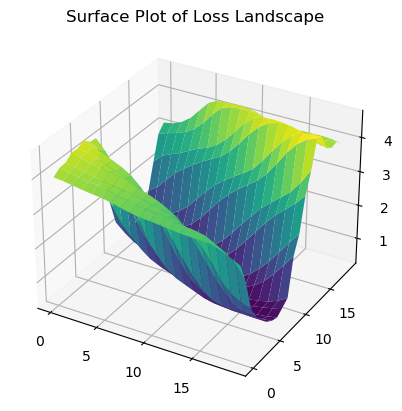

In [49]:
x, y = iter(trainloader).__next__()
STEPS = 20
metric = loss_landscapes.metrics.Loss(criterion, x, y)
model = resnet56.cpu()

loss_data_fin = loss_landscapes.random_plane(model, metric, 2, STEPS, normalization='filter', deepcopy_model=True)
fig = plt.figure()
ax = plt.axes(projection='3d')
X = np.array([[j for j in range(STEPS)] for i in range(STEPS)])
Y = np.array([[i for _ in range(STEPS)] for i in range(STEPS)])
ax.plot_surface(X, Y, loss_data_fin, rstride=1, cstride=1, cmap='viridis', edgecolor='none')
ax.set_title('Surface Plot of Loss Landscape')
fig.show()

# No residual connection

In [16]:
W_resnet56 = model_cifar.ResNet56_noshort()


In [25]:
optimizer = torch.optim.SGD(W_resnet56.parameters(), lr=0.01)
train(W_resnet56, criterion, optimizer, trainloader, testloader, epochs=20, log_interval=2)

  5%|▌         | 1/20 [00:46<14:35, 46.09s/it]

Validation loss: 1.5701773196836062
Validation accuracy: 0.6445806962025317


 15%|█▌        | 3/20 [02:18<13:05, 46.19s/it]

Validation loss: 1.6321570541285262
Validation accuracy: 0.6458662974683544


 25%|██▌       | 5/20 [03:51<11:34, 46.31s/it]

Validation loss: 1.6906919026676612
Validation accuracy: 0.6448773734177216


 35%|███▌      | 7/20 [05:24<10:02, 46.33s/it]

Validation loss: 1.7567924110195305
Validation accuracy: 0.6442840189873418


 45%|████▌     | 9/20 [06:57<08:31, 46.49s/it]

Validation loss: 1.8122399607791175
Validation accuracy: 0.6420094936708861


 55%|█████▌    | 11/20 [08:30<06:59, 46.56s/it]

Validation loss: 1.8529928696306446
Validation accuracy: 0.643690664556962


 55%|█████▌    | 11/20 [08:55<07:17, 48.64s/it]


KeyboardInterrupt: 

In [26]:
torch.save(W_resnet56.state_dict(), 'W_resnet56.pth')

C:\Users\Pierre\AppData\Local\Temp\ipykernel_9268\2396723446.py:13: UserWarning: Matplotlib is currently using module://matplotlib_inline.backend_inline, which is a non-GUI backend, so cannot show the figure.
  fig.show()


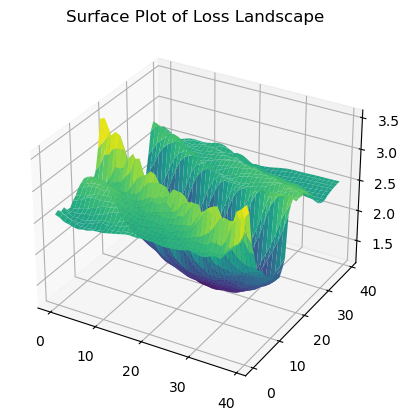

In [37]:
x, y = iter(testloader).__next__()
STEPS = 40
metric = loss_landscapes.metrics.Loss(criterion, x, y)
model = W_resnet56.cpu()

loss_data_fin = loss_landscapes.random_plane(model, metric, 2, STEPS, normalization='filter', deepcopy_model=True)
fig = plt.figure()
ax = plt.axes(projection='3d')
X = np.array([[j for j in range(STEPS)] for i in range(STEPS)])
Y = np.array([[i for _ in range(STEPS)] for i in range(STEPS)])
ax.plot_surface(X, Y, loss_data_fin, rstride=1, cstride=1, cmap='viridis', edgecolor='none')
ax.set_title('Surface Plot of Loss Landscape')
fig.show()

C:\Users\Pierre\AppData\Local\Temp\ipykernel_9268\1462757593.py:13: UserWarning: Matplotlib is currently using module://matplotlib_inline.backend_inline, which is a non-GUI backend, so cannot show the figure.
  fig.show()


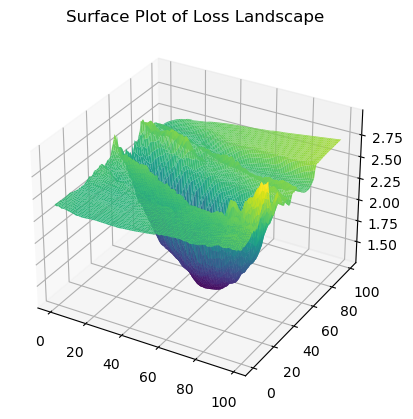

In [26]:
x, y = iter(testloader).__next__()
STEPS = 100
metric = loss_landscapes.metrics.Loss(criterion, x, y)
model = W_resnet56.cpu()

loss_data_fin = loss_landscapes.random_plane(model, metric, 1, STEPS, normalization='filter', deepcopy_model=True)
fig = plt.figure()
ax = plt.axes(projection='3d')
X = np.array([[j for j in range(STEPS)] for i in range(STEPS)])
Y = np.array([[i for _ in range(STEPS)] for i in range(STEPS)])
ax.plot_surface(X, Y, loss_data_fin, rstride=1, cstride=1, cmap='viridis', edgecolor='none')
ax.set_title('Surface Plot of Loss Landscape')
fig.show()

# Even deeper network

In [25]:
W_resnet110 = model_cifar.ResNet110_noshort()

In [35]:
optimizer = torch.optim.SGD(W_resnet110.parameters(), lr=0.01, weight_decay=0.0005)
scheduler = torch.optim.lr_scheduler.StepLR(optimizer, gamma=0.1, step_size=75)
train(W_resnet110, criterion, optimizer, trainloader, testloader, epochs=300, cur_val_loss=2.0)

  0%|          | 0/300 [00:00<?, ?it/s]

  0%|          | 1/300 [01:49<9:06:45, 109.72s/it]

Validation loss: 1.9153990820993352
Validation accuracy: 0.28827136075949367


  4%|▎         | 11/300 [15:15<6:28:15, 80.61s/it]

Validation loss: 1.9167055102843273
Validation accuracy: 0.2901503164556962


  7%|▋         | 21/300 [28:38<6:13:35, 80.34s/it]

Validation loss: 1.9155975368958484
Validation accuracy: 0.29736946202531644


 10%|█         | 31/300 [42:02<6:00:17, 80.36s/it]

Validation loss: 1.921274595622775
Validation accuracy: 0.2884691455696203


 14%|█▎        | 41/300 [55:25<5:46:47, 80.34s/it]

Validation loss: 1.9171973240526416
Validation accuracy: 0.29608386075949367


 17%|█▋        | 51/300 [1:08:49<5:33:35, 80.39s/it]

Validation loss: 1.9073885890501965
Validation accuracy: 0.2979628164556962


 20%|██        | 61/300 [1:22:13<5:20:08, 80.37s/it]

Validation loss: 1.9087200557129294
Validation accuracy: 0.2993473101265823


 24%|██▎       | 71/300 [1:35:36<5:06:26, 80.29s/it]

Validation loss: 1.9217059219939798
Validation accuracy: 0.29410601265822783


 27%|██▋       | 81/300 [1:48:59<4:53:18, 80.36s/it]

Validation loss: 1.9183291438259655
Validation accuracy: 0.2912381329113924


 30%|███       | 91/300 [2:02:23<4:39:52, 80.35s/it]

Validation loss: 1.9079114500480363
Validation accuracy: 0.2990506329113924


 34%|███▎      | 101/300 [2:15:48<4:26:54, 80.47s/it]

Validation loss: 1.9072479039807864
Validation accuracy: 0.2967761075949367


 37%|███▋      | 111/300 [2:29:12<4:13:27, 80.46s/it]

Validation loss: 1.914810200280781
Validation accuracy: 0.2955893987341772


 40%|████      | 121/300 [2:42:37<4:00:09, 80.50s/it]

Validation loss: 1.8984570035451576
Validation accuracy: 0.307753164556962


 44%|████▎     | 131/300 [2:56:02<3:46:37, 80.46s/it]

Validation loss: 1.909626157977913
Validation accuracy: 0.2998417721518987


 47%|████▋     | 141/300 [3:09:26<3:33:05, 80.41s/it]

Validation loss: 1.908396385893037
Validation accuracy: 0.30982990506329117


 50%|█████     | 151/300 [3:22:50<3:19:45, 80.44s/it]

Validation loss: 1.8999033879630174
Validation accuracy: 0.30963212025316456


 54%|█████▎    | 161/300 [3:36:15<3:06:19, 80.43s/it]

Validation loss: 1.9187265785434577
Validation accuracy: 0.3037974683544304


 57%|█████▋    | 171/300 [3:49:39<2:52:59, 80.46s/it]

Validation loss: 1.9121249280398405
Validation accuracy: 0.31052215189873417


 60%|██████    | 181/300 [4:03:04<2:39:37, 80.48s/it]

Validation loss: 1.9178592298604265
Validation accuracy: 0.3076542721518987


 64%|██████▎   | 191/300 [4:16:29<2:26:12, 80.48s/it]

Validation loss: 1.9432092754146721
Validation accuracy: 0.30547863924050633


 67%|██████▋   | 201/300 [4:29:54<2:12:46, 80.47s/it]

Validation loss: 1.9299752998955642
Validation accuracy: 0.3061708860759494


 70%|██████▉   | 209/300 [4:40:45<2:02:14, 80.60s/it]


KeyboardInterrupt: 

In [32]:
torch.save(W_resnet110.state_dict(), 'W_resnet110_weights.pth')

In [33]:
#load the weights
W_resnet110.load_state_dict(torch.load('W_resnet110_weights.pth'))

<All keys matched successfully>